In [1]:
import pandas as pd
import numpy as np
from sklearn import linear_model, metrics
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
import torch
import torch.utils.data as data_utils
import sys
from tqdm import tqdm
from utils import *

sys.path.insert(0, '../VAE')
sys.path.insert(0, '.')
#from hdf_dataset import HDFDataset
#from sklearn.tree import DecisionTreeClassifier
#from sklearn.ensemble import AdaBoostClassifier
#from sklearn.neural_network import MLPClassifier

# Preprocessing
We normalize the features, shuffle it and create a training-test split. In addition I check the effect of second order polynomial features.

In [3]:
POLY_DEG = 1
NORMALIZE = False
DATASET_DIR = "/Users/rotem/PycharmProjects/NAF/external_maf/datasets/data/lhc"
DATASET_PATH_TEMPLATE = "{}/{}"
df = pd.read_hdf(DATASET_PATH_TEMPLATE.format(DATASET_DIR, "events_anomalydetection_v2.features.h5"))
y = df["label"]
signal = y == 1
delta_mj = np.abs(df['mj1'] - df['mj2'])
mjj = get_mjj(df)
epsilon = 1e-5
tau_21j1 = (df['tau2j1'] / df['tau1j1']).fillna(0) + epsilon
tau_21j2 = (df['tau2j2'] / df['tau1j2']).fillna(0) + epsilon

X = df.loc[:, df.columns != "label"]
if NORMALIZE:
    mean = X.mean()
    std = X.std()
    X = (X - mean) / std
poly = PolynomialFeatures(POLY_DEG)
X = pd.DataFrame(poly.fit_transform(X), columns=poly.get_feature_names(X.columns))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
df.describe()

,pxj1,pyj1,pzj1,mj1,tau1j1,tau2j1,tau3j1,pxj2,pyj2,pzj2,mj2,tau1j2,tau2j2,tau3j2,label
count,1.100000e+06,1.100000e+06,1.100000e+06,1.100000e+06,1.100000e+06,1.100000e+06,1.100000e+06,1.100000e+06,1.100000e+06,1.100000e+06,1.100000e+06,1.100000e+06,1.100000e+06,1.100000e+06,1.100000e+06
mean,-1.327996e+00,2.602047e+00,1.200619e-01,2.195990e+02,1.363843e+02,5.571819e+01,3.742071e+01,1.132151e+00,-2.496534e+00,-8.540738e-01,2.089902e+02,1.290355e+02,5.338557e+01,3.605997e+01,9.090909e-02
std,1.001400e+03,1.001730e+03,1.153441e+03,1.647181e+02,1.382575e+02,4.940572e+01,2.998556e+01,8.847728e+02,8.851543e+02,1.163099e+03,1.527055e+02,1.286603e+02,4.670867e+01,2.837653e+01,2.874799e-01
min,-3.880100e+03,-3.320690e+03,-5.587720e+03,-2.642900e-05,0.000000e+00,0.000000e+00,0.000000e+00,-3.740480e+03,-3.406180e+03,-5.490730e+03,-3.411970e-05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,-9.695655e+02,-9.663385e+02,-7.231380e+02,9.768073e+01,4.287708e+01,2.281695e+01,1.619798e+01,-7.972635e+02,-8.014985e+02,-7.380858e+02,9.543755e+01,4.065460e+01,2.221150e+01,1.605428e+01,0.000000e+00
50%,-1.785130e+00,5.091580e+00,1.598670e+00,1.629155e+02,8.372715e+01,4.143035e+01,2.934835e+01,2.593420e+00,-5.038455e+00,2.205830e-01,1.597260e+02,8.109740e+01,3.981480e+01,2.856560e+01,0.000000e+00
75%,9.659120e+02,9.702918e+02,7.237895e+02,2.998730e+02,1.776495e+02,7.149420e+01,4.973332e+01,8.002305e+02,7.979622e+02,7.365130e+02,2.836275e+02,1.699862e+02,6.866177e+01,4.770973e+01,0.000000e+00
max,3.852430e+03,3.484770e+03,6.155580e+03,1.615690e+03,1.473960e+03,7.564940e+02,4.504640e+02,3.630150e+03,3.295420e+03,5.620940e+03,1.508690e+03,1.464820e+03,7.450410e+02,4.914610e+02,1.000000e+00


## Visualization
Below I present histograms for all of the features.
Polynomial features seem to improve signal-bg separation.

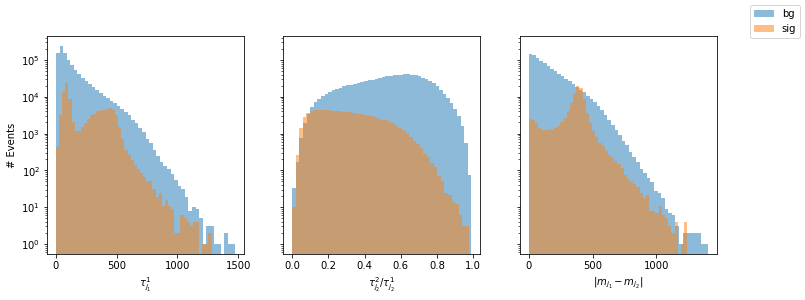

In [150]:
fig, axs = plt.subplots(1, 3, sharey=True)
fig.set_size_inches(12, 4)
epsilon = 10**-5
alpha = 0.5
delta_mj = np.abs(df['mj1'] - df['mj2'])
axs[2].hist(delta_mj[~signal], label='bg', bins=50, alpha=0.5)
axs[2].hist(delta_mj[signal], label='sig', bins=50, alpha=0.5)
axs[2].set_yscale('log')
axs[2].set_xlabel("$|m_{j_1} - m_{j_2}|$")
axs[0].hist(df['tau1j1'][~signal].to_numpy(), bins=50, alpha=0.5)
axs[0].hist(df['tau1j1'][signal].to_numpy(), bins=50, alpha=0.5)
axs[0].set_yscale('log')
axs[0].set_xlabel("$\\tau^{1}_{j_1}$")
axs[1].hist(tau_21j1[~signal], bins=50, alpha=0.5)
axs[1].hist(tau_21j1[signal], bins=50, alpha=0.5)
axs[1].set_yscale('log')
axs[1].set_xlabel("$\\tau^{2}_{j_2} / \\tau^{1}_{j_2}$")
axs[0].set_ylabel('# Events')
fig.legend()
fig.savefig('observable_histograms.png', dpi=400)

Plots of all variables

In [ ]:
for column in X_test.columns:
    X_test.hist(column=column, bins=50)
    X_test[y_test == 1].hist(column=column, bins=50)

Correlation with label, a high absolute value means the feature is a good indicator of signal.
We see the polynomial features sometimes exceed the non-polynomial ones.

In [20]:
X.drop('1',axis=1, inplace=True)

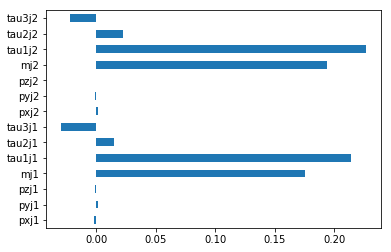

In [76]:
X.corrwith(y).plot(kind='barh')
plt.savefig('observable_correlations.png', dpi=400)

## PCA and further analysis
We see $\tau_{j_1}, \tau_{j_2}, m_{j_1}, m_{j_2}$ contains the most variance followed by $\vec{p}_{j_1}, \vec{p}_{j_2}$

             PC0       PC1       PC2       PC3       PC4       PC5       PC6  \
1      -0.000000  0.000000  0.000000 -0.000000 -0.000000 -0.000000 -0.000000   
pxj1    0.289583 -0.691997 -0.014328 -0.000795 -0.000437  0.000073 -0.641751   
pyj1    0.692125  0.289517  0.000063 -0.003423 -0.000178 -0.000088  0.158979   
pzj1   -0.001732  0.012812 -0.685228  0.728214  0.000193 -0.000162 -0.000179   
mj1     0.000153  0.000134  0.000099 -0.000063  0.732616  0.170618 -0.000786   
tau1j1  0.000146  0.000055  0.000078 -0.000061  0.607740  0.148813 -0.000182   
tau2j1 -0.000012 -0.000015  0.000009 -0.000019  0.173732  0.043608  0.000267   
tau3j1 -0.000002  0.000007  0.000003 -0.000011  0.100120  0.023910  0.000106   
pxj2   -0.255036  0.609812  0.012692  0.000408 -0.000582  0.000137 -0.728282   
pyj2   -0.609907 -0.255216 -0.000008  0.002993  0.000042  0.000440  0.180241   
pzj2    0.008448 -0.012218  0.728077  0.685334 -0.000016 -0.000060 -0.000114   
mj2     0.000244  0.000027 -0.000084  0.

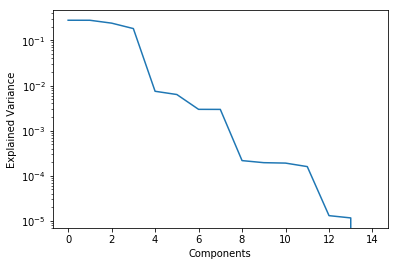

In [6]:
pca = PCA(n_components=X.shape[1])
pca.fit(X)

# Reformat and view results
loadings = pd.DataFrame(pca.components_.T,
                        columns=['PC%s' % _ for _ in range(len(X.columns))],
                        index=X.columns)
print(loadings)

plt.plot(pca.explained_variance_ratio_)
plt.yscale('log')
plt.ylabel('Explained Variance')
plt.xlabel('Components')
plt.show()

Rotating into the PCs we see the PCs that differentiate well between signal and background: 1, 6, 8, 10, 11

/Users/rotem/opt/anaconda3/envs/NAF/lib/python2.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


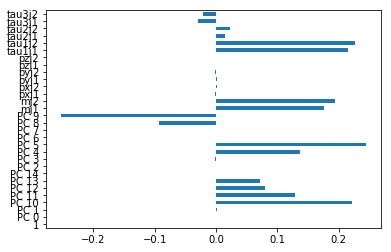

In [7]:
X_pca = pd.DataFrame(data=pca.transform(X), columns=["PC {}".format(i) for i in range(len(X.columns))])
pd.concat([X, X_pca]).corrwith(y).plot(kind='barh')
#plt.plot(np.linspace(0, X.shape[1]-1, X.shape[1]), np.abs(np.corrcoef(X_pca.T, y)[:-1, -1]), '.')
#plt.xlabel("PC")
#plt.ylabel(r"$|\rho|$")
#plt.yscale('log')

## Linear classifier test
To assess the quality of the features we use we can check how well a linear classifier fits the label of the training set to them.

Some simple NNs and decision trees are tested for reference.

When successful, this means that the non-linearity differentiating between the signal and background is captured by the features.

In [16]:
models = {"Linear_1e-5": linear_model.SGDClassifier(alpha=1e-5)}
#          "BDT_1_100":  AdaBoostClassifier(DecisionTreeClassifier(max_depth=2), n_estimators=100),
#          "MLP_10_10": MLPClassifier(hidden_layer_sizes=(10, 10)),
#          "MLP_5_5": MLPClassifier(hidden_layer_sizes=(5, 5))}

for name in models:
    models[name].fit(X_train, y_train)

A ROC curve is used to evaluate the effectiveness of the classification.

Linear_1e-5: 0.0864454545455


Text(0,0.5,'TPR')

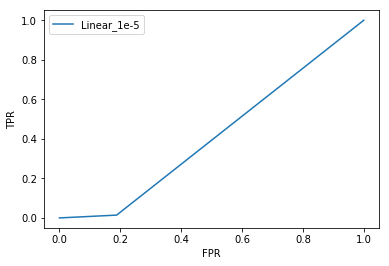

In [18]:
for name in models:
    model = models[name]
    mse = metrics.mean_squared_error(y_test, model.predict(X_test))
    print(f"{name}: {mse}")
    tpr, fpr, thresh = metrics.roc_curve(y_test, model.predict(X_test))
    plt.plot(fpr, tpr, label=name)
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")

# VAE
Now lets give it a go using a $\beta$-VAE.

In [158]:
from beta1_vae_model import *
import matplotlib as mpl
mpl.rcParams['agg.path.chunksize'] = 10**8
model_cp_path_format = 'models/vae_lhc_141263_negKLD_nsig{}.pt'
cols = ['vae141263_negKLD kld nsig{}'.format(10**i) for i in range(2,6)]
scores = pd.read_csv('external_maf/datasets/data/lhc/lhc_vae_density.csv')
#model_cp_path_format = 'models/vae_lhc_mjj_bin_141263_{}of10.pt'
#data_path_format = 'external_maf/datasets/data/lhc/lhc_mjj_bin_{}of10.npy'

Training loop

In [93]:
for i in range(2, 6):
    nsig = 10**i
    ds = get_n_signal_dataset(nsig, df)
    cp_path = model_cp_path_format.format(nsig)
    train_and_save_model(ds, cp_path)

AttributeError: 'tuple' object has no attribute 'shape'

In [ ]:
# old training loop
for i in range(5, 11):
    ds_path = data_path_format.format(i)
    cp_path = model_cp_path_format.format(i)
    train_and_save_model(ds_path, cp_path)

Load and get scores

100%|██████████| 4/4 [00:28<00:00,  7.16s/it]
/Users/rotem/opt/anaconda3/envs/NAF/lib/python2.7/site-packages/matplotlib/axes/_base.py:3471: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=1e-11, top=1e-11
  'bottom=%s, top=%s') % (bottom, top))


,vae141263_negKLD kld nsig100,vae141263_negKLD kld nsig1000,vae141263_negKLD kld nsig10000,vae141263_negKLD kld nsig100000
count,1.100000e+06,1.100000e+06,1.100000e+06,1.100000e+06
mean,2.402221e+00,2.227020e+00,2.227020e+00,2.402221e+00
std,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
min,2.402221e+00,2.227020e+00,2.227020e+00,2.402221e+00
25%,2.402221e+00,2.227020e+00,2.227020e+00,2.402221e+00
50%,2.402221e+00,2.227020e+00,2.227020e+00,2.402221e+00
75%,2.402221e+00,2.227020e+00,2.227020e+00,2.402221e+00
max,2.402221e+00,2.227020e+00,2.227020e+00,2.402221e+00


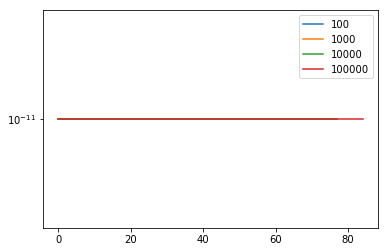

In [159]:
df = pd.read_csv('external_maf/datasets/data/lhc/lhc_features_and_bins.csv')
scores = pd.read_csv('external_maf/datasets/data/lhc/lhc_vae_density.csv')
dataset = NumpyDataset(df.to_numpy()[:, :-3])
dataloader = data_utils.DataLoader(dataset, batch_size=dataset.length, shuffle=False)
for i in tqdm([10**j for j in range(2, 6)]):
    model, _, losses, _ = load(model_cp_path_format.format(i))#, [14, 12, 6, 3], 1.e-5)
    model.eval()
    _, mask = get_n_signal_dataset(i, df)
    scores['vae141263 mask nsig{}'.format(i)] = np.logical_and(mask, signal)
    losses = np.array(losses)
    losses[losses <= 0] = 10**-11
    mean_losses = [np.mean(losses[10000*k:10000*(k+1)]) for k in range(losses.shape[0] / 10000)]
    plt.plot(mean_losses, label=str(i))
    for x in dataloader:
        scores['vae141263_negKLD density nsig{}'.format(i)] = model.density(x).detach().numpy()
        scores['vae141263_negKLD kld nsig{}'.format(i)] = model.get_losses(x).detach().numpy()
plt.legend()
plt.yscale('log')
scores[cols].describe()

# events in cut: 11001
% signal: 0.235789710177
% original signal: 0.00235902044484


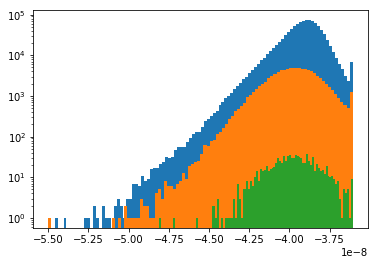

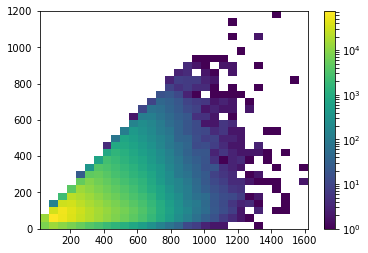

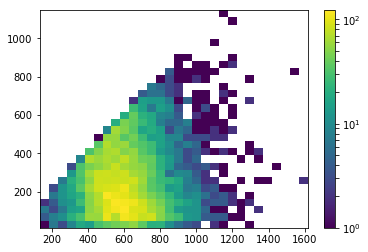

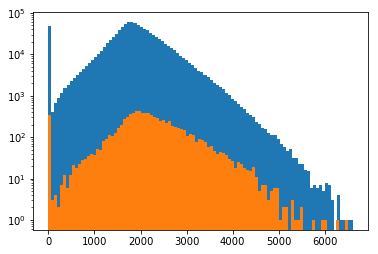

In [154]:
i = 1
original_sig = scores['vae141263 mask nsig{}'.format(10**(i+2))]
plt.hist(scores[cols[i]][~signal], bins=100, label='bg')
plt.hist(scores[cols[i]][signal], bins=100, label='sig')
plt.hist(scores[cols[i]][original_sig], bins=100)
plt.yscale('log')
cut =(scores[cols[i]].quantile(0.) <= scores[cols[i]]) & (scores[cols[i]] <= scores[cols[i]].quantile(0.01))
print("# events in cut: {}".format(np.sum(cut)))
print("% signal: {}".format(1.0 * np.sum(np.logical_and(cut, signal)) / np.sum(np.logical_and(cut, ~signal))))
print("% original signal: {}".format(1.0 * np.sum(np.logical_and(cut, original_sig)) / np.sum(np.logical_and(cut, ~signal))))
cut = np.logical_and(cut, np.logical_or(~signal, original_sig))
plot_mj(df, np.logical_or(original_sig, ~signal), cut, bins=[30,30])
plt.figure()
plt.hist(mjj[np.logical_or(original_sig, ~signal)], bins=100)
#plt.hist(mjj[signal], bins=100)
plt.hist(mjj[cut], bins=100)
plt.yscale('log')
#plt.hist(df['tau1j2'][cut], bins=100)

In [59]:
scores[cols[i]].quantile(0.99)

-3.2972211627679826e-09

In [ ]:
template = 'vae141263 density nsig{}'
for i in [10**j for j in range(2,6)]:
    plt.figure()
    plt.hist(scores[template.format(i)][~signal], bins=50)
    plt.hist(scores[template.format(i)][signal], bins=50)
    plt.hist(scores[template.format(i)][scores['vae141263 mask nsig{}'.format(i)]], bins=50)
    plt.title(i)
    plt.yscale('log')
ratio = scores[template.format(10**5)] - scores[template.format(10**3)]
plt.figure()
plt.hist(ratio[~signal], bins=50)
plt.hist(ratio[signal], bins=50)
plt.yscale('log')

In [10]:
scores.to_csv('external_maf/datasets/data/lhc/lhc_vae_density.csv', index=False)

count    1.160000e+02
mean     2.692701e-06
std      6.740688e-06
min      4.046829e-07
25%      4.798613e-07
50%      7.756081e-07
75%      1.640328e-06
max      4.455743e-05
Name: vae141263 kld 7of10, dtype: float64


0.2413793103448276

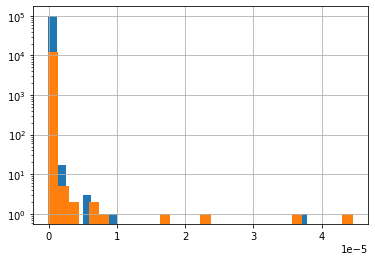

In [112]:
bin_num = 7
scores['vae141263 kld {}of10'.format(bin_num)][np.logical_and(~signal, df['mjj_bin_num'] == bin_num)].hist(bins=30)
scores['vae141263 kld {}of10'.format(bin_num)][np.logical_and(signal, df['mjj_bin_num'] == bin_num)].hist(bins=30)
plt.yscale('log')
united = pd.concat([df, scores], axis=1)
cut = np.logical_and(df['mjj_bin_num'] == bin_num, scores['vae141263 kld {}of10'.format(bin_num)] >= 4e-7)
print(scores['vae141263 kld {}of10'.format(bin_num)][cut].describe())
np.sum(df['label'][cut]) / np.sum(cut)

## Creating bins and datasets
We create the different bins from the data for training purposes, $m_{jj}$ is chosen as the discriminatory variable

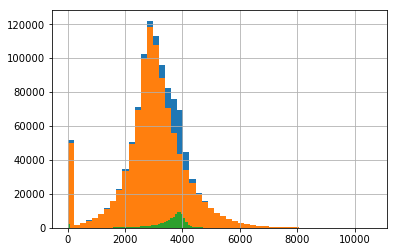

In [4]:
signal = df['label'] == 1
mjj = get_mjj(df)
mjj = mjj / mjj[signal].mean() * 3500  # seems not to match the expected value for some reason so I fixed it
mjj.hist(bins=50)
mjj[df['label'] == 0].hist(bins=50)
mjj[signal].hist(bins=100)

In [7]:
q = 8
df["mjj_bins"] = pd.qcut(mjj, q=q, precision=100)
df["mjj_bin_num"] = pd.qcut(mjj, q=q, labels=[i for i in range(1, q + 1)])
df["mjj_bins"].unique()

[(3683.2247394, 4112.08100007], (3049.41386997, 3330.37081506], (3330.37081506, 3683.2247394], (1993.99444952, 2529.03184498], (4112.08100007, 10605.6093931], (2529.03184498, 2808.17367577], (2808.17367577, 3049.41386997], (-1e-100, 1993.99444952]]
Categories (8, interval[float64]): [(-1e-100, 1993.99444952] < (1993.99444952, 2529.03184498] < (2529.03184498, 2808.17367577] < (2808.17367577, 3049.41386997] < (3049.41386997, 3330.37081506] < (3330.37081506, 3683.2247394] < (3683.2247394, 4112.08100007] < (4112.08100007, 10605.6093931]]

In [8]:
# Need to make sure it is done with python 2.7 for unpickle to work
lower_sig_df, lower_sig_mask = get_n_signal_dataset(1000, df)
for i in range(int(q / 2), q + 1):
    x = df[np.logical_and(df["mjj_bin_num"] == i, lower_sig_mask)].to_numpy()[:, :-3]
    print(x.shape[0])
    np.save("external_maf/datasets/data/lhc/lhc_mjj_bin_{}of{}.npy".format(i, q), x, allow_pickle=True)
df.to_csv("external_maf/datasets/data/lhc/lhc_features_and_bins.csv", index=False)

132841
128957
116967
92435
129248


For sanity plotting the jet mass difference

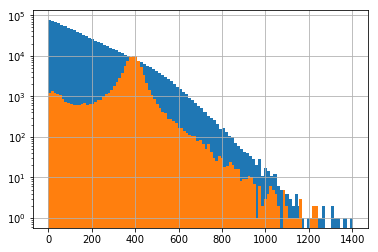

In [75]:
fig, ax = plt.subplots()

param = delta_mj
param[~signal].hist(bins=100)
param[signal].hist(bins=100)
plt.yscale('log')

# Testing the flow models in different bins
A plot of $R = \frac{p_{sig+bg}}{p_{bg}}$ should indicate which events are anomalous. In order to do this we add columns to the dataset for the models' density estimation for each event.

In [164]:
densities = pd.read_csv("external_maf/datasets/data/lhc/lhc_ddsf_density.csv")
united = pd.concat([df, densities], axis=1)

In [167]:
united

,pxj1,pyj1,pzj1,mj1,tau1j1,tau2j1,tau3j1,pxj2,pyj2,pzj2,...,tau1j2,tau2j2,tau3j2,label,mjj_bins,mjj_bin_num,lhc_binned_en2of5_sp0_e40_s1993_p0.0_h100_fddsf_fl5_l1_dsdim16_dsl1_cudaFalse_best,lhc_binned_en3of5_sp0_e40_s1993_p0.0_h100_fddsf_fl5_l1_dsdim16_dsl1_cudaFalse_best,lhc_binned_en4of5_sp0_e40_s1993_p0.0_h100_fddsf_fl5_l1_dsdim16_dsl1_cudaFalse_best,lhc_binned_en5of5_sp0_e40_s1993_p0.0_h100_fddsf_fl5_l1_dsdim16_dsl1_cudaFalse_best
0,-1467.239990,611.502014,511.101990,38.896000,8.290660,4.836080,4.260190,1403.579956,-674.551025,-451.670990,...,79.815102,21.010300,16.757601,0.0,"(3269.1459151, 3838.87087541]",4,-81.146460,-83.998800,-74.128110,-75.798195
1,-1211.239990,347.315002,547.963013,389.532013,191.804001,99.562798,70.872200,619.341003,-62.177299,-1944.040039,...,8.042190,6.335090,5.525360,0.0,"(2855.56913405, 3269.1459151]",3,-81.261950,-79.383630,-80.400790,-89.138610
2,-1229.619995,649.857971,8.089170,72.155502,47.168098,37.243198,33.658199,1196.250000,-647.896973,-1283.109985,...,15.292900,13.944200,10.013500,0.0,"(2855.56913405, 3269.1459151]",3,-76.373570,-74.707140,-75.555980,-80.174805
3,-693.304016,-1046.729980,1716.910034,55.797798,24.788601,6.890150,5.813390,747.961975,994.250000,-412.966003,...,175.209000,103.500999,84.447098,0.0,"(3269.1459151, 3838.87087541]",4,-93.889350,-84.238940,-77.279785,-85.586395
4,-1488.199951,-25.370100,-30.989700,84.891502,26.878799,15.517200,13.260400,1415.640015,20.905100,223.630997,...,57.986000,34.147400,26.660601,0.0,"(3269.1459151, 3838.87087541]",4,-79.661750,-72.032650,-71.875880,-78.151505
5,1326.140015,269.324005,-1271.780029,53.948399,11.506400,10.161400,9.411340,-968.528992,-206.539993,-377.338013,...,113.532997,33.889999,24.068501,0.0,"(-1e-100, 2366.80126755]",1,-81.590980,-96.750830,-92.965740,-120.891010
6,-775.677979,-2023.099976,3144.820068,220.046005,53.900799,45.947899,27.183100,732.945007,1842.589966,-680.747986,...,92.549202,67.849403,44.551998,0.0,"(3838.87087541, 10605.6093931]",5,-130.627140,-133.841220,-113.948105,-86.438290
7,-1082.270020,728.283020,459.272003,83.232903,20.681700,13.263800,8.205660,984.085999,-842.546021,-354.402008,...,179.731003,98.685997,76.239502,0.0,"(2855.56913405, 3269.1459151]",3,-82.005615,-76.320970,-78.894230,-96.143160
8,1142.890015,-1073.359985,-1124.130005,47.442600,26.315500,12.864700,6.368740,-948.323975,978.437988,-20.598200,...,206.108994,92.154198,71.715500,0.0,"(3269.1459151, 3838.87087541]",4,-92.727950,-80.030205,-79.098570,-90.610725
9,-992.776001,-797.679016,-442.100006,148.080994,66.295097,50.591900,41.325298,870.721008,736.559998,-305.916992,...,14.227500,7.014760,4.870040,0.0,"(2366.80126755, 2855.56913405]",2,-71.018810,-77.317550,-86.295580,-96.016090


count    180858.000000
mean          5.891524
std           2.346182
min         -36.291735
25%           4.496018
50%           6.051475
75%           7.347778
max         329.419875
dtype: float64
count    39142.000000
mean         5.891503
std          2.656072
min         -9.197110
25%          4.394385
50%          5.853693
75%          7.311571
max        290.363105
dtype: float64


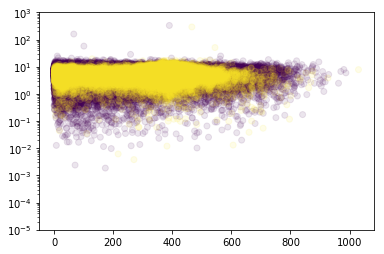

<Figure size 432x288 with 0 Axes>

In [256]:
column_template = 'lhc_binned_en{}of{}_sp0_e40_s1993_p0.0_h100_fddsf_fl5_l1_dsdim16_dsl1_cudaFalse_best'.format('{}', q)
#column_template = 'lhc_binned_en{}of{}_sp0_e400_s1993_p0.0_h100_faffine_fl5_l1_dsdim16_dsl1_cudaFalse_best'.format('{}', q)
#column_template = 'vae141263 density {}of10'
signal_region = [4]
log_psig = np.mean([united[column_template.format(sr)] for sr in signal_region], axis=0)
log_pbg = 0.5 * (united[column_template.format(max(signal_region) + 1)] + united[column_template.format(min(signal_region) - 1)])
#log_psig = np.log(np.mean([np.exp(united[column_template.format(sr)]) for sr in signal_region], axis=0))
#log_pbg = np.log(0.5 * (np.exp(united[column_template.format(max(signal_region) + 1)]) + np.exp(united[column_template.format(min(signal_region) - 1)])))
#log_psig[log_psig == -np.inf] = -750.
#log_pbg[log_pbg == -np.inf] = -750.
logR = log_psig - log_pbg
bin_mask = False
for sr in signal_region:
    bin_mask = np.logical_or(bin_mask, df['mjj_bin_num'] == sr)
plt.scatter(x=delta_mj[bin_mask], y=logR[bin_mask], c=df['label'][bin_mask], alpha=0.1)
plt.yscale('log')
plt.ylim(1e-5, 1000)
plt.figure()
print(logR[np.logical_and(~signal, bin_mask)].describe())
print(logR[np.logical_and(signal, bin_mask)].describe())


Events in cut: 1540
% signal in cut: 0.281818181818
% signal in bin: 0.177918181818


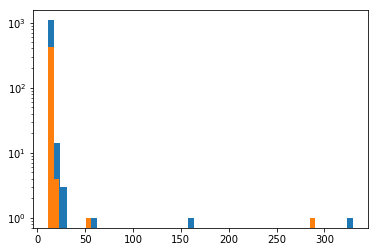

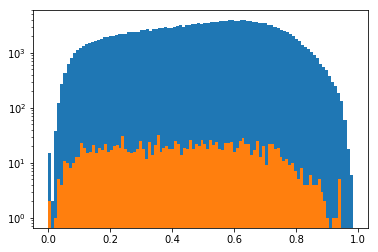

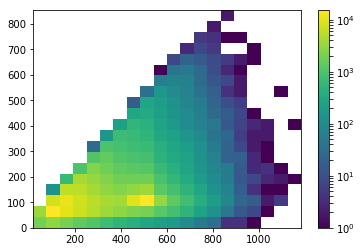

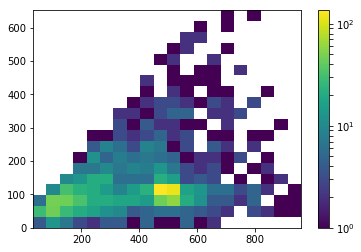

In [257]:
cut = np.logical_and((logR >= logR[bin_mask].quantile(0.993)), bin_mask)
print("Events in cut: {}".format(np.sum(cut)))
plt.hist(logR[np.logical_and(cut, ~signal)], bins=50)
plt.hist(logR[np.logical_and(cut, signal)], bins=50)
plt.yscale('log')
print("% signal in cut: {}".format(np.sum(1.0*np.logical_and(cut, signal))/np.sum(cut)))
print("% signal in bin: {}".format(np.sum(1.0*np.logical_and(bin_mask, signal))/np.sum(bin_mask)))
plt.figure()
plt.hist(tau_21j2[bin_mask], bins=100)
plt.hist(tau_21j2[cut], bins=100)
plt.yscale('log')
plot_mj(df, bin_mask, cut, bins=[20,20])

100%|██████████| 100/100 [00:02<00:00, 40.11it/s]


Cut quantile: 0.99 
Signal percent: 0.28
Bin signal percent: 0.177918181818


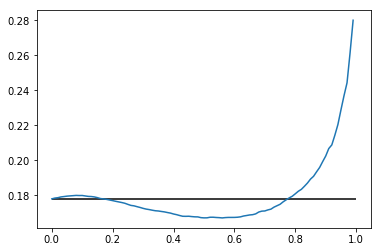

In [258]:
plot_cuts(logR, bin_mask, signal, 100)

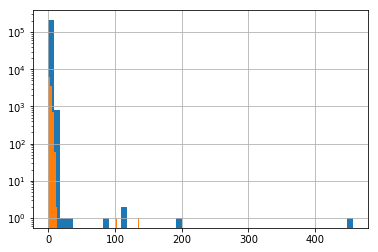

In [236]:
logR[np.logical_and(~signal, bin_mask)].hist(bins=50)
logR[np.logical_and(signal, bin_mask)].hist(bins=50)
plt.yscale('log')

In [44]:
logR[bin_mask].describe()

count    220000.000000
mean          2.790909
std           1.846460
min         -32.690039
25%           1.549868
50%           2.853266
75%           4.103331
max          58.514181
dtype: float64

Signal/Total in cut: 1587.0/14538 = 0.10916219562525795


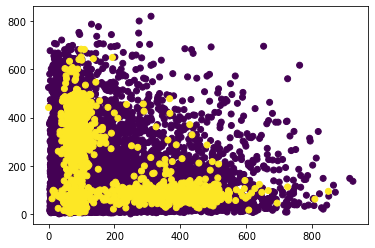

In [56]:
#cut = np.logical_and(logR >= 15, bin_mask)
cut = np.logical_and(logR >= 2, bin_mask)
total_cut = np.sum(cut)
signal_in_cut = np.sum(df['label'][cut])
ratio = signal_in_cut / total_cut
print("Signal/Total in cut: {}/{} = {}".format(signal_in_cut, total_cut, ratio))
plt.scatter(x=df['tau1j1'][cut], y=df['tau1j2'][cut], c=df['label'][cut])

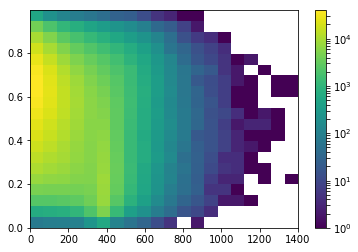

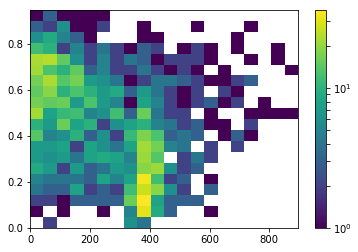

In [229]:
plt.figure()
plt.hist2d(x=delta_mj, y=tau_21j2, bins=[20, 20], norm=mpl.colors.LogNorm())
plt.colorbar()
plt.figure()
plt.hist2d(x=delta_mj[cut], y=tau_21j2[cut], bins=[20, 20], norm=mpl.colors.LogNorm())
plt.colorbar()